# Imports

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
%matplotlib inline
from sklearn import tree
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Load Data

In [17]:
LOANS_TRAIN = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/LOANS_TRAIN.csv')
LOANS_TEST = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/LOANS_TEST.csv')

In [18]:
LOANS_TRAIN

,id,loan_amnt,term_(months),int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status
0,0,5000,36,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,credit_card,Computer,860xx,AZ,27.65,Jan-1985,3,0,13648,83.7%,9,f,Individual,NaN,0.0,Fully Paid
1,1,2500,60,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,car,bike,309xx,GA,1.00,Apr-1999,3,0,1687,9.4%,4,f,Individual,NaN,0.0,Charged Off
2,2,2400,36,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,small_business,real estate business,606xx,IL,8.72,Nov-2001,2,0,2956,98.5%,10,f,Individual,NaN,0.0,Fully Paid
3,3,10000,36,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,other,personel,917xx,CA,20.00,Feb-1996,10,0,5598,21%,37,f,Individual,NaN,0.0,Fully Paid
4,4,3000,60,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,other,Personal,972xx,OR,17.94,Jan-1996,15,0,27783,53.9%,38,f,Individual,NaN,0.0,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197245,199995,1500,36,7.90%,46.94,A,A4,USAF,5 years,RENT,42000.0,Source Verified,Sep-2012,other,Auto Repairs,890xx,NV,18.23,Aug-2005,5,0,3597,29.5%,10,f,Individual,0.0,0.0,Fully Paid
197246,199996,14075,36,8.90%,446.93,A,A5,NaN,NaN,RENT,36000.0,Verified,Sep-2012,credit_card,Credit card refinancing,891xx,NV,22.20,Jun-1972,15,0,17473,47.1%,24,f,Individual,0.0,0.0,Fully Paid
197247,199997,11000,36,14.09%,376.44,B,B5,Gateway Regional Medical Center,2 years,RENT,45000.0,Not Verified,Sep-2012,debt_consolidation,Debt Consolidation,631xx,MO,8.91,Oct-2006,18,0,8956,43.7%,20,f,Individual,0.0,0.0,Fully Paid
197248,199998,31400,60,22.95%,884.28,F,F1,Navy Federal Credit Union,3 years,MORTGAGE,85000.0,Verified,Sep-2012,debt_consolidation,debt free plan!,220xx,VA,24.76,Oct-1999,12,0,23150,77.4%,23,f,Individual,4.0,0.0,Charged Off


#Data Wrangling
In this section, we handle all of the train and test data. Both sets are handled identically (we probably should have made a function lol), with numerical columns kept the same and categorical columns made into numerical columns. Categorical columns were either directly translated to numbers if there was a way that made sense, otherwise they were encoded using one-hot encoding or dropped entirely (if there were too many unique categories). For addr_state, since there were 50 unqiue categories, which was too much for one-hot encoding but still seemed like an important variable to keep, we used target encoding.

In [19]:
train_data = pd.DataFrame()
## Changes that are applied as we manipulate the data into train_data

#Keep loan amount the same
train_data['loan_amnt'] = LOANS_TRAIN['loan_amnt']
#Keep loan term the same, only has 36 or 60
train_data['term'] = LOANS_TRAIN['term_(months)']
#Convert interest rate to a float
train_data['int_rate'] = [float(x.strip(" ").strip("%")) 
                              for x in LOANS_TRAIN['int_rate']]
#Keep installment the same
train_data['installment'] = LOANS_TRAIN['installment']
#Change grade from A-G to 0-6
train_data['grade'] = [ord(x)-65 for x in LOANS_TRAIN['grade']]
#Change subgrade from A1-G5 to 0-4,10-14,..,60-64
train_data['sub_grade'] = [10*(ord(x[0])-65)+int(x[1])-1 
                              for x in LOANS_TRAIN['sub_grade']]
#Dropping emp_title column because 119834 unique out of 197249 total
#Convert emp length from <1, 1, ..., 9, 10+ to 0-10, nan value coded as -1 
train_data['emp_length'] = [-1 if pd.isna(x) else 0 if '<' in x 
                            else int(x.strip(" years").strip("+")) 
                            for x in LOANS_TRAIN['emp_length']]
#Home ownership has rent, own, mortgage, other, none: making a column for each 
train_data['ownership_rent'] = [1 if x == 'RENT' else 0 
                                for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_own'] = [1 if x == 'OWN' else 0 
                               for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_mortgage'] = [1 if x == 'MORTGAGE' else 0 
                                    for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_other'] = [1 if x == 'OTHER' else 0 
                                 for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_none'] = [1 if x == 'NONE' else 0 
                                for x in LOANS_TRAIN['home_ownership']]
#Keep annual income the same
train_data['annual_inc'] = LOANS_TRAIN['annual_inc']
#Verification status has verified, source verified, not verified, so making a 
#column for each of these
train_data['status_verified'] = [1 if x == 'Verified' else 0 
                                 for x in LOANS_TRAIN['verification_status']]
train_data['status_source_verified'] = [1 if x == 'Source Verified' else 0 
                                  for x in LOANS_TRAIN['verification_status']]
train_data['status_not_verified'] = [1 if x == 'Not Verified' else 0 
                                  for x in LOANS_TRAIN['verification_status']]
#Split into issue year and issue month
#Issue year changed from 2007-2013 to 0-6
train_data['issue_year'] = [int(x[-4:])-2007 for x in LOANS_TRAIN['issue_d']]
#Issue month changed from jan-dec to 0-11
train_data['issue_month'] = [datetime.strptime(x[:3], "%b").month-1 
                             for x in LOANS_TRAIN['issue_d']]
#Purpose has multiple options so making a column for each of these
train_data['purpose_credit_card'] = [1 if x == 'credit_card' else 0 
                                     for x in LOANS_TRAIN['purpose']]
train_data['purpose_car'] = [1 if x == 'car' else 0 
                             for x in LOANS_TRAIN['purpose']]
train_data['purpose_small_business'] = [1 if x == 'small_business' else 0 
                                        for x in LOANS_TRAIN['purpose']]
train_data['purpose_other'] = [1 if x == 'other' else 0 
                               for x in LOANS_TRAIN['purpose']]
train_data['purpose_wedding'] = [1 if x == 'wedding' else 0 
                                 for x in LOANS_TRAIN['purpose']]
train_data['purpose_debt_consolidation'] = [1 if x == 'debt_consolidation' 
                                        else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_home_improvement'] = [1 if x == 'home_improvement' else 0 
                                          for x in LOANS_TRAIN['purpose']]
train_data['purpose_major_purchase'] = [1 if x == 'major_purchase' else 0 
                                        for x in LOANS_TRAIN['purpose']]
train_data['purpose_medical'] = [1 if x == 'medical' else 0 
                                 for x in LOANS_TRAIN['purpose']]
train_data['purpose_moving'] = [1 if x == 'moving' else 0 
                                for x in LOANS_TRAIN['purpose']]
train_data['purpose_vacation'] = [1 if x == 'vacation' else 0 
                                  for x in LOANS_TRAIN['purpose']]
train_data['purpose_house'] = [1 if x == 'house' else 0 
                               for x in LOANS_TRAIN['purpose']]
train_data['purpose_renewable_energy'] = [1 if x == 'renewable_energy' else 0 
                                          for x in LOANS_TRAIN['purpose']]
train_data['purpose_educational'] = [1 if x == 'educational' else 0 
                                     for x in LOANS_TRAIN['purpose']]
#Dropping title column because 53461 unique out of 197249 total
#Dropping zip_code column because 855 unique out of 197249 total, 
#could also do numerical as below
# train_data['zip_code'] = [int(x[:3]) for x in LOANS_TRAIN['zip_code']]
#Keep dti the same
train_data['dti'] = LOANS_TRAIN['dti']
#Split into issue year and issue month
#Issue year changed from 1946-2010 to 0-64
train_data['cr_line_year'] = [int(x[-4:])-1946 
                              for x in LOANS_TRAIN['earliest_cr_line']]
#Issue month changed from jan-dec to 0-11
train_data['cr_line_month'] = [datetime.strptime(x[:3], "%b").month-1 
                               for x in LOANS_TRAIN['earliest_cr_line']]
#Keep open_acc the same
train_data['open_acc'] = LOANS_TRAIN['open_acc']
#Keep pub_rec the same
train_data['pub_rec'] = LOANS_TRAIN['pub_rec']
#Keep revol_bal the same
train_data['revol_bal'] = LOANS_TRAIN['revol_bal']
#Convert revol_util to a float
train_data['revol_util'] = [-1 if pd.isna(x) else float(x.strip("%")) 
for x in LOANS_TRAIN['revol_util']]
#Keep total_acc the same
train_data['total_acc'] = LOANS_TRAIN['total_acc']
#Convert initial_list_status from f/w to 0/1
train_data['initial_list_status'] = [0 if x == 'f' else 1 
                                    for x in LOANS_TRAIN['initial_list_status']]
#Convert nan values to -1 for pub_rec_bankruptcies
train_data['pub_bankruptcies'] = [-1 if pd.isna(x) else x 
                                  for x in LOANS_TRAIN['pub_rec_bankruptcies']]
#Dropping application type because all of them are individual
#Convert nan values to -1 for mort_acc
train_data['mort_acc'] = [-1 if pd.isna(x) else x 
                          for x in LOANS_TRAIN['mort_acc']]

train_data['loan_status'] = [1 if x == 'Charged Off' else 0 
                             for x in LOANS_TRAIN['loan_status']]
#Setting intermediate states as the original states
train_data['addr_state'] = LOANS_TRAIN['addr_state']
#Target encoding the states
state_means = {}
for x in train_data['addr_state'].unique():
  state_means[x] = train_data[train_data['addr_state']==x]['loan_status'].mean()
train_data['addr_state'] = [state_means[x] for x in train_data['addr_state']]
#Dropping the loan status labels
train_data.drop('loan_status', inplace=True, axis=1)

train_labels = pd.DataFrame()
#Making our loan_status with 0 as charged off and 1 as fully paid
train_labels['loan_status'] = [1 if x == 'Charged Off' else 0 
                               for x in LOANS_TRAIN['loan_status']]

In [20]:
train_data

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,ownership_rent,ownership_own,ownership_mortgage,ownership_other,ownership_none,annual_inc,status_verified,status_source_verified,status_not_verified,issue_year,issue_month,purpose_credit_card,purpose_car,purpose_small_business,purpose_other,purpose_wedding,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_moving,purpose_vacation,purpose_house,purpose_renewable_energy,purpose_educational,dti,cr_line_year,cr_line_month,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,pub_bankruptcies,mort_acc,addr_state
0,5000,36,10.65,162.87,1,11,10,1,0,0,0,0,24000.0,1,0,0,4,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,27.65,39,0,3,0,13648,83.7,9,0,0.0,-1.0,0.151597
1,2500,60,15.27,59.83,2,23,0,1,0,0,0,0,30000.0,0,1,0,4,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.00,53,3,3,0,1687,9.4,4,0,0.0,-1.0,0.141727
2,2400,36,15.96,84.33,2,24,10,1,0,0,0,0,12252.0,0,0,1,4,11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8.72,55,10,2,0,2956,98.5,10,0,0.0,-1.0,0.140521
3,10000,36,13.49,339.31,2,20,10,1,0,0,0,0,49200.0,0,1,0,4,11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20.00,50,1,10,0,5598,21.0,37,0,0.0,-1.0,0.149500
4,3000,60,12.69,67.79,1,14,1,1,0,0,0,0,80000.0,0,1,0,4,11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,17.94,50,0,15,0,27783,53.9,38,0,0.0,-1.0,0.137840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197245,1500,36,7.90,46.94,0,3,5,1,0,0,0,0,42000.0,0,1,0,5,8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,18.23,59,7,5,0,3597,29.5,10,0,0.0,0.0,0.190010
197246,14075,36,8.90,446.93,0,4,-1,1,0,0,0,0,36000.0,1,0,0,5,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,22.20,26,5,15,0,17473,47.1,24,0,0.0,0.0,0.190010
197247,11000,36,14.09,376.44,1,14,2,1,0,0,0,0,45000.0,0,0,1,5,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8.91,60,9,18,0,8956,43.7,20,0,0.0,0.0,0.161613
197248,31400,60,22.95,884.28,5,50,3,0,0,1,0,0,85000.0,1,0,0,5,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,24.76,53,9,12,0,23150,77.4,23,0,0.0,4.0,0.155638


In [21]:
test_data = pd.DataFrame()

## Changes that are applied as we manipulate the data into test_data 
## since most changes are the same, only differences are explained in depth here

#Keep loan amount the same
test_data['loan_amnt'] = LOANS_TEST['loan_amnt']
#Keep loan term the same
test_data['term'] = LOANS_TEST['term_(months)']
#Convert interest rate to a float
test_data['int_rate'] = [float(x.strip(" ").strip("%")) 
                              for x in LOANS_TEST['int_rate']]
#Keep installment the same
test_data['installment'] = LOANS_TEST['installment']
#Change grade from A-G to 0-6
test_data['grade'] = [ord(x)-65 for x in LOANS_TEST['grade']]
#Change subgrade from A1-G5 to 0-4,10-14,..,60-64
test_data['sub_grade'] = [10*(ord(x[0])-65)+int(x[1])-1 
                          for x in LOANS_TEST['sub_grade']]
#Dropping emp_title column
#Convert emp length to 0-10, nan value coded as -1 
test_data['emp_length'] = [-1 if pd.isna(x) else 0 if '<' in x 
                           else int(x.strip(" years").strip("+")) 
                           for x in LOANS_TEST['emp_length']]
#Making a column for each category of home ownership
test_data['ownership_rent'] = [1 if x == 'RENT' else 0 
                               for x in LOANS_TEST['home_ownership']]
test_data['ownership_own'] = [1 if x == 'OWN' else 0 
                              for x in LOANS_TEST['home_ownership']]
test_data['ownership_mortgage'] = [1 if x == 'MORTGAGE' else 0 
                                   for x in LOANS_TEST['home_ownership']]
test_data['ownership_other'] = [1 if x == 'OTHER' else 0 
                                for x in LOANS_TEST['home_ownership']]
test_data['ownership_none'] = [1 if x == 'NONE' else 0 
                               for x in LOANS_TEST['home_ownership']]
#Keep annual income the same
test_data['annual_inc'] = LOANS_TEST['annual_inc']
#Making a column for each category of verification status
test_data['status_verified'] = [1 if x == 'Verified' else 0 
                                for x in LOANS_TEST['verification_status']]
test_data['status_source_verified'] = [1 if x == 'Source Verified' else 0 
                                    for x in LOANS_TEST['verification_status']]
test_data['status_not_verified'] = [1 if x == 'Not Verified' else 0 
                                    for x in LOANS_TEST['verification_status']]
#Split into issue year and issue month
#Issue year changed from 2007-2013 to 0-6
test_data['issue_year'] = [int(x[-4:])-2007 for x in LOANS_TEST['issue_d']]
#Issue month changed from jan-dec to 0-11
test_data['issue_month'] = [datetime.strptime(x[:3], "%b").month-1 
                            for x in LOANS_TEST['issue_d']]
#Making a column for each category of purpose
test_data['purpose_credit_card'] = [1 if x == 'credit_card' else 0 
                                    for x in LOANS_TEST['purpose']]
test_data['purpose_car'] = [1 if x == 'car' else 0 
                            for x in LOANS_TEST['purpose']]
test_data['purpose_small_business'] = [1 if x == 'small_business' else 0 
                                       for x in LOANS_TEST['purpose']]
test_data['purpose_other'] = [1 if x == 'other' else 0 
                              for x in LOANS_TEST['purpose']]
test_data['purpose_wedding'] = [1 if x == 'wedding' else 0 
                                for x in LOANS_TEST['purpose']]
test_data['purpose_debt_consolidation'] = [1 if x == 'debt_consolidation' else 0 
                                           for x in LOANS_TEST['purpose']]
test_data['purpose_home_improvement'] = [1 if x == 'home_improvement' else 0 
                                         for x in LOANS_TEST['purpose']]
test_data['purpose_major_purchase'] = [1 if x == 'major_purchase' else 0 
                                       for x in LOANS_TEST['purpose']]
test_data['purpose_medical'] = [1 if x == 'medical' else 0 
                                for x in LOANS_TEST['purpose']]
test_data['purpose_moving'] = [1 if x == 'moving' else 0 
                               for x in LOANS_TEST['purpose']]
test_data['purpose_vacation'] = [1 if x == 'vacation' else 0 
                                 for x in LOANS_TEST['purpose']]
test_data['purpose_house'] = [1 if x == 'house' else 0 
                              for x in LOANS_TEST['purpose']]
test_data['purpose_renewable_energy'] = [1 if x == 'renewable_energy' else 0 
                                         for x in LOANS_TEST['purpose']]
test_data['purpose_educational'] = [1 if x == 'educational' else 0 
                                    for x in LOANS_TEST['purpose']]
#Dropping title column
#Dropping zip_code column
#Keep dti the same
test_data['dti'] = LOANS_TEST['dti']
#Split into issue year and issue month
#Issue year changed from 1946-2010 to 0-64
test_data['cr_line_year'] = [int(x[-4:])-1946 
                             for x in LOANS_TEST['earliest_cr_line']]
#Issue month changed from jan-dec to 0-11
test_data['cr_line_month'] = [datetime.strptime(x[:3], "%b").month-1 
                              for x in LOANS_TEST['earliest_cr_line']]
#Keep all of the following the same
test_data['open_acc'] = LOANS_TEST['open_acc']
test_data['pub_rec'] = LOANS_TEST['pub_rec']
test_data['revol_bal'] = LOANS_TEST['revol_bal']
#Convert revol_util to a float
test_data['revol_util'] = [-1 if pd.isna(x) else float(x.strip("%")) 
                              for x in LOANS_TEST['revol_util']]
#Keep total_acc the same
test_data['total_acc'] = LOANS_TEST['total_acc']
#Convert initial_list_status from f/w to 0/1
test_data['initial_list_status'] = [0 if x == 'f' else 1 
                                    for x in LOANS_TEST['initial_list_status']]
#Convert nan values to -1 for pub_rec_bankruptcies
test_data['pub_bankruptcies'] = [-1 if pd.isna(x) else x 
                                 for x in LOANS_TEST['pub_rec_bankruptcies']]
#Dropping application type
#Convert nan values to -1 for mort_acc
test_data['mort_acc'] = [-1 if pd.isna(x) else x 
                         for x in LOANS_TEST['mort_acc']]
#Target encoding for states
test_data['addr_state'] = LOANS_TEST['addr_state']
test_data['addr_state'] = [state_means[x] if x in state_means 
                           else train_labels['loan_status'].mean() 
                           for x in test_data['addr_state']]

#Models

###XGBoost

Our top performing model was an XGBoost model. When investigating the XGBoost model, we first just played around with some basic XGBoost code.

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_data, label=train_labels)
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
bst = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(test_data)
ypred = bst.predict(dtest)

We then did a random search using the RandomizedSearchCV from the sklearn modelselection package on some parameters to get a good baseline model on which to grid search each individual parameter. This example has only 2 folds for 3 total parameter combinations for the sake of running it in the colab notebook, but it was ran with 5 folds for 30 parameter combinations.

In [ ]:
from xgboost import XGBClassifier
# Random Search
# Parameter options
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 300, 600],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.01, 0.1]
        }
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, nthread=4)

Y=train_labels.values.ravel()

folds = 2
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(train_data,Y), verbose=3, random_state=1001 )

# Here we go
random_search.fit(train_data, Y)

print(random_search.cv_results_)
print(random_search.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
{'mean_fit_time': array([ 49.86313748,  75.14504004, 225.60658777]), 'std_fit_time': array([0.05635262, 0.16130185, 0.86652887]), 'mean_score_time': array([1.24625325, 1.4074775 , 5.50823629]), 'std_score_time': array([0.03935528, 0.11347544, 0.43873465]), 'param_subsample': masked_array(data=[0.6, 0.8, 0.8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100, 100, 600],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 5, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 7],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.001, 0.001, 0.1],
             mask=[False, False, False],
  

We then did a grid search on each parameter seperately (to save time as opposed to searching all the parameters together, some parameters were initially searched as pairs) and updated our set of optimal parameters. Our final model that we submitted was created from this code, so was a 5 fold cross-validation XGBoost model with the parameters specified below.

In [ ]:
# Grid Search
# Parameter options
params = {
        'min_child_weight': [3],
        'gamma': [7],
        'subsample': [0.7],
        'colsample_bytree': [0.9],
        'n_estimators': [600],
        'max_depth': [3],
        'learning_rate': [0.07],
        'reg_alpha': [2],
        'reg_lambda': [5]
        }
# params['min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# params['gamma'] = [4,5,6,6.5,7,8,9,10,12]
# params['subsample'] = [0.6, 0.7, 0.8, 0.9, 1.0]
# params['colsample_bytree'] = [0.6, 0.7, 0.8, 0.9, 1.0]
# params['n_estimators'] = [600, 700, 800, 900, 1000]
# params['max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# params['learning_rate'] = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
# params['reg_alpha'] = [2,3,3.5,4,6,8,11]
# params['reg_lambda'] = [2,3,3.5,4,6,8,11]

xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, nthread=4)

Y=train_labels.values.ravel()

folds = 5
# param_comb = 30

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

grid_search = GridSearchCV(xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(train_data,Y), verbose=3)

# Here we go
grid_search.fit(train_data, Y)

print(grid_search.cv_results_)
print(grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'mean_fit_time': array([391.97926669]), 'std_fit_time': array([141.15103786]), 'mean_score_time': array([1.5234118]), 'std_score_time': array([0.53199227]), 'param_colsample_bytree': masked_array(data=[0.9],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[7],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.07],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[2],
   

###Feature Importance (XGBoost)

Replicating XGBoost model for feature importance analysis.

In [ ]:
dtrain = xgb.DMatrix(train_data, label=train_labels, feature_names=list(train_data.columns))
param = {
    'max_depth': 3,
    'min_child_weight': 3,
    'gamma': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'n_estimators': 600, 
    'eta': 0.07, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
    }
num_round = 100
bst = xgb.train(param, dtrain, num_round)

Plotting feature importance using weight measurement.  Weight is related to how many times a feature is utilized to split the data across the decision trees.

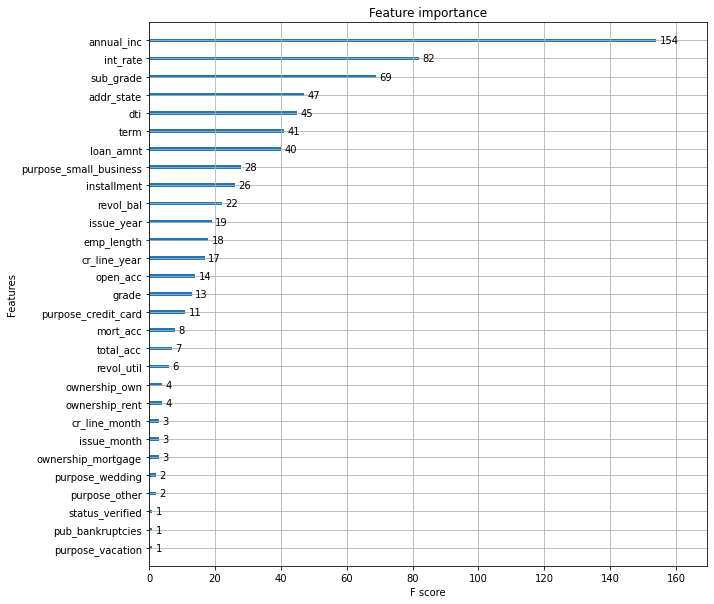

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="weight")
plt.show()

Plotting feature importance using gain measurement.  Gain is related to the the average training loss reduction that was gain when a feature is utilized for splitting.

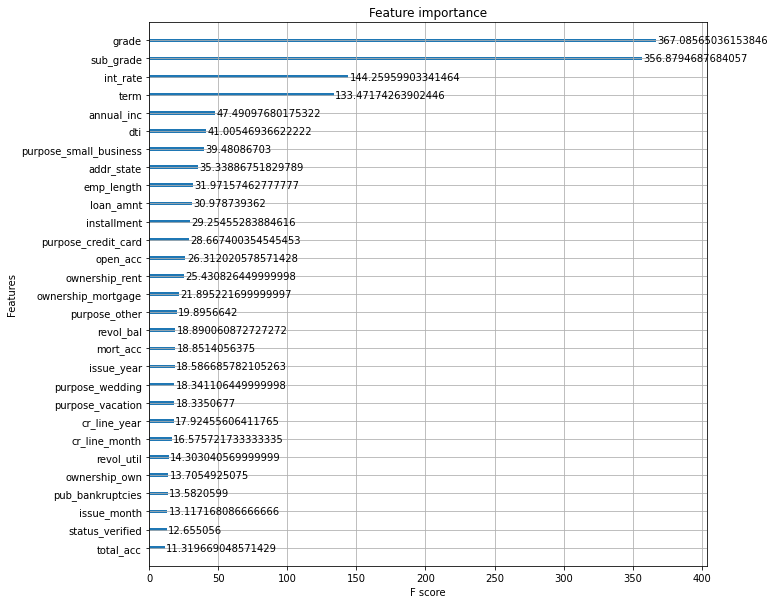

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="gain")
plt.show()

Plotting feature importance using cover measurement.  Cover is similar to weight, but this measure is also weighted by how many training points pass through the data splits.

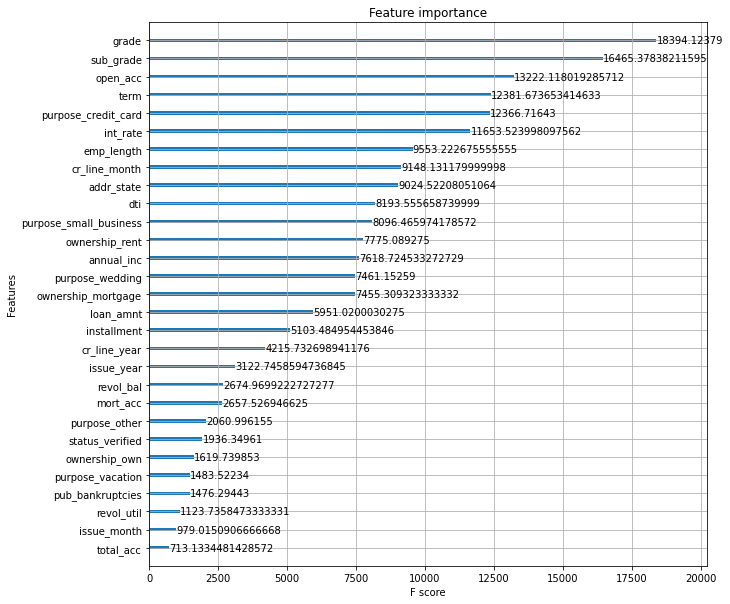

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="cover")
plt.show()

###Random Forest

Our second-best performing model was a RandomForest model. When investigating the RandomForest model, we first converted all of the data into the necessary shapes for training.

In [22]:
train_labels = np.array(train_labels['loan_status'])
train_features = np.array(train_data)
test_features = np.array(test_data)

In [23]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)

Training Features Shape: (197250, 44)
Training Labels Shape: (197250,)
Testing Features Shape: (42480, 44)


We then did a random search using the RandomizedSearchCV from the sklearn modelselection package.  We did not further use GridSearchCV for this model, as when we were performing RandomizedSearchCV, we simply tested each parameter in pairs and saved the best performing parameter to utilize in the next parameter's testing.  For example, we show below a randomized search using different max features values.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
#n_estimators = [100,300,500]
#n_estimators = [500,600,700]
n_estimators = 600 #best performing parameter
n_estimators = [100,600] #for the sake of displaying code process
#max_features = ['sqrt',0.2]
max_features = ['sqrt'] #best performing parameter
#max_depth = [1,5,10,None]
#max_depth = [20,50,None]
max_depth = [None] #best performing parameter
#random_state = [21,42,50]
random_state = [50] #best performing parameter -- however the model that we 
#selected utilizes random_state = 42, as that performed the best on testing
#min_samples_leaf = [10,30,50,100]
#min_samples_leaf = [30,40,50]
#min_samples_leaf = [25,30,35]
min_samples_leaf = [30] #best performing parameter
#bootstrap = [true,false]
# ignored bootstrap as it gave me the same values either way

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state
            #    'bootstrap': bootstrap
}
print(random_grid)

{'n_estimators': [100, 600], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_leaf': [30], 'random_state': [50]}


In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(oob_score=True) #wanted to use out of batch scoring as well 

When performing each search iteration, we would utilize 3-fold cross validation and an n_iter that corresponded to the number of parameter options being tested.

In [32]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 2, cv = 3, n_jobs = -1,
                               return_train_score=True,scoring='roc_auc')
rf_random.fit(train_features, train_labels)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(oob_score=True),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [30],
                                        'n_estimators': [100, 600],
                                        'random_state': [50]},
                   return_train_score=True, scoring='roc_auc')

In [33]:
rf_random.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 30,
 'n_estimators': 600,
 'random_state': 50}